<hr style="border: solid 3px blue;">

# 1. Introduction

DCGAN uses the image created by the creator. Therefore, after training, we discard the discriminator and use only the generator to create a plausible generative image.
In this notebook, we implement and train DCGAN using simple handwriting.

![](https://miro.medium.com/max/920/1*fN-q2XG9CTii8S6Xh8SIyg.gif)

Picture Credit: https://miro.medium.com

-------------------------------------------
# Setting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings , os
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import umap
import umap.plot

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# input image dimension
img_shape = (img_rows, img_cols, channels)

# size of noise vector to be used as generator input
z_dim = 100

-----------------------------------
# Modeling

![](https://i.pinimg.com/originals/1d/6c/f3/1d6cf3dd8f447252b97475b7c6efe6d2.gif)

Picture Credit: https://i.pinimg.com


> The generative network generates candidates while the discriminative network evaluates them. The contest operates in terms of data distributions. Typically, the generative network learns to map from a latent space to a data distribution of interest, while the discriminative network distinguishes candidates produced by the generator from the true data distribution. The generative network's training objective is to increase the error rate of the discriminative network (i.e., "fool" the discriminator network by producing novel candidates that the discriminator thinks are not synthesized (are part of the true data distribution)).

Ref: https://en.wikipedia.org/wiki/Generative_adversarial_network

**Now, let's model the generator and discriminator so that they compete against each other.**

-------------------------------------
# Modeling Generator

![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Picture credit: https://pytorch.org

The generator starts at the noise vector z. We use a fully connected layer to transform this vector into a 3D output with a small area and large length. Using transposed convolution, the output is gradually changed to decrease the depth and increase the area. When we reach the last layer, the size of the image will be the size we need 28 x 28 x 1.

In [3]:
def build_generator(z_dim):

    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

---------------------------------------------
# Modeling Discriminator

![](https://miro.medium.com/max/1600/1*UipjlvULzSCCr1szzZpKYQ.jpeg)
picture credit: https://miro.medium.com

The discriminator is a ConvNet similar to a convolution network that takes an image and outputs a prediction vector. In this case, the binary classifier determines whether the input image is fake or real.

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

------------------------------------------------
# Modeling GAN

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()

    # Genearator -> Discriminator
    model.add(generator)
    model.add(discriminator)

    return model

# Creating discriminator

In [6]:
# Creating and Compiling discriminator Models
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
# Preserve the parameters of the discriminator while training the generator
discriminator.trainable = False


# Creating generator

In [7]:
# Create a generator model
generator = build_generator(z_dim)

# Create and compile a GAN model with frozen discriminators to train the generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Defining training function

In [8]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # [0, 255] scales black and white pixel values between [-1, 1]
    X_train = x_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Real Image Label: All 1
    real = np.ones((batch_size, 1))

    # Fake Image Labels: All 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # -------------------------
        #  Discriminant training
        # -------------------------

        # Get random batches from real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Create fake image batches
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Training 
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Training generator
        # ---------------------

        # Create fake image batches
        z = np.random.normal(0, 1, (batch_size, 100))
        
        if iteration == 0:
            print("\nRandom noise input image")
            sample_images(x_train[idx],y_train[idx],generator)            

        g_loss = gan.train_on_batch(z, real)

        if iteration < 200 and (iteration + 1) % 20 == 0:
            # Save loss and accuracy to plot graphs after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Generated image sample output
            sample_images(x_train[idx],y_train[idx],generator)
            
        elif (iteration + 1) % sample_interval == 0:
            # Save loss and accuracy to plot graphs after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Generated image sample output
            sample_images(x_train[idx],y_train[idx],generator)

-------------------------------------------------------------------
# Sampling and drawing images

In [9]:
image_grid_rows=4
image_grid_columns=4
    
def plot_dim_reduction(imgs, gen_imgs, img_labels):
    sns.set(style="ticks", context="talk",font_scale = 1)
    plt.style.use("dark_background")
    markers=['o','v','^','<','>','8','s','P','*','X','+','*']    
    plt.figure(figsize=(9,9))
    reshape_real_imgs = imgs.reshape(imgs.shape[0], -1)
    reshape_gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], -1)*255
    concat_imgs = np.concatenate([reshape_real_imgs,reshape_gen_imgs])
    fake_label = np.empty((image_grid_rows * image_grid_columns))
    fake_label[:] = 11
    concat_label = np.concatenate([img_labels,fake_label])
    mapper = umap.UMAP().fit_transform(concat_imgs)
    for i,marker in enumerate(markers):
        mask = concat_label == i
        if i == 11:
            plt.scatter(mapper[mask, 0], mapper[mask, 1], label=i, s=100, alpha=1,marker=marker, c ='yellow')
        else:
            plt.scatter(mapper[mask, 0], mapper[mask, 1], label=i, s=10, alpha=1,marker=marker)
    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)     
    plt.title("Plotting real and generated images after dimension reduction",fontsize = 15)

In [10]:
def plot_dist(gen_imgs):
    sns.set(style="ticks", context="talk",font_scale = 1)
    plt.style.use("dark_background")
    plt.figure(figsize=(10,6))
    sns.distplot(gen_imgs,color='purple',kde=True)
    plt.title("Generated Images Distribution",fontsize = 20)
    plt.show()

In [11]:
def sample_images(imgs, img_labels, generator):
    # random noise sampling
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    # Generate Image from Random Noise
    gen_imgs = generator.predict(z)  
    
    # Scale image pixel values between [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    plot_dim_reduction(imgs, gen_imgs, img_labels)
    plot_dist(gen_imgs)

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(11, 11),
                            sharey=True,
                            sharex=True)

    cnt = 0
    #plt.figure(figsize=(9,9))
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='Greys_r')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

--------------------------------------------------------------
# Setting Hyperparameters

In [12]:
# Setting Hyperparameter
iterations = 3201
batch_size = 128
sample_interval = 400

------------------------------------------------------------------------------------
# Training

![](https://miro.medium.com/max/517/1*okBKjQcLOpeswTyZZfvZWA.png)

Picture Credit: https://miro.medium.com

Now, we will train using the designed GAN model. Since we do not know the distribution of the real dataset at first, we assume that the distribution of the real dataset is a normal distribution. The generator and discriminator of the GAN model will train in adversarial competition. That is, the generator will produce fakes that look like the real ones, and the discriminators will be trained to discriminate whether they are real or fake. Now let's visually see how the training is actually going.

To understand the operation of GAN, we would like to draw three plots as follows.
* **UMAP plot**: After reducing the dimensionality of real images and generated images to two dimensions, I try drawing them in a specific iteration during training. Even though, it is a compression of the high dimension of $28 * 28$ into two dimensions, it seems sufficient to understand the operation of the GAN.
Additionally, GANs are unlabeled as Unsupervised Learning. Therefore, the label of the generated image was arbitrarily decided as 11, and it was expressed by a yellow star.
* **Distribution of Generated Images**: It shows how GAN learns distributions of real images by changing the distribution of generated images.
* **Generated images**: I drew the images generated by the generator.

**Now, let's trust our model and go on a long journey, shall we?**

11501568/11490434 [==============================] - 0s 0us/step

Random noise input image


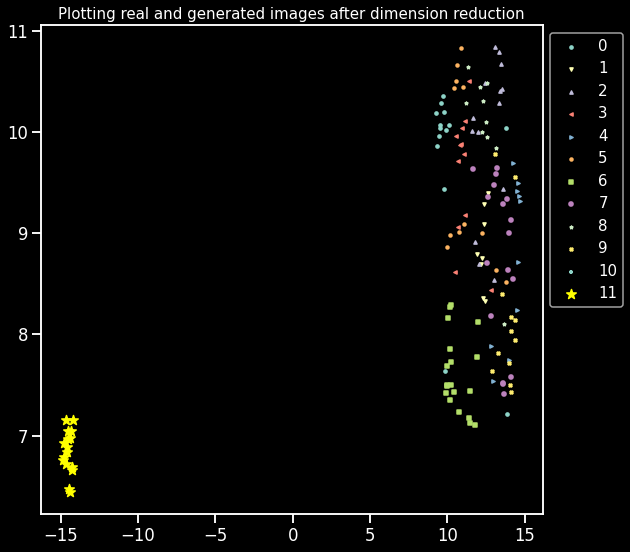

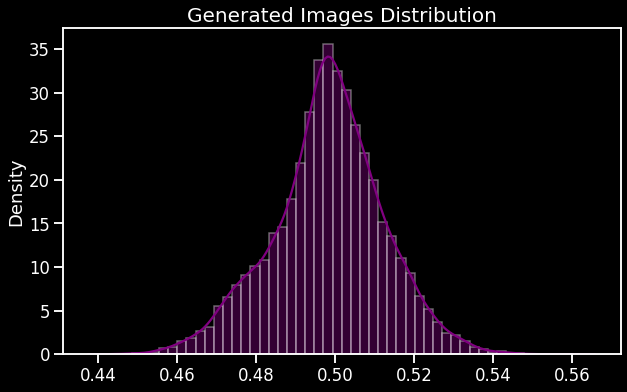

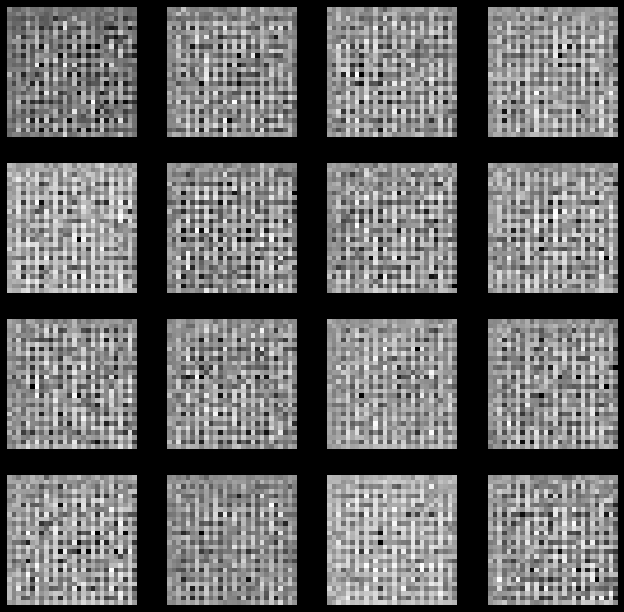

20 [D loss: 0.245093, accuracy: 100.00%] [G loss: 0.737960]


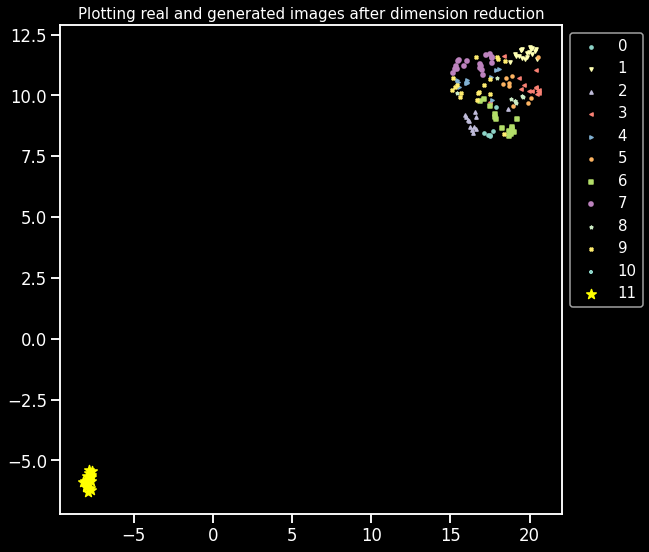

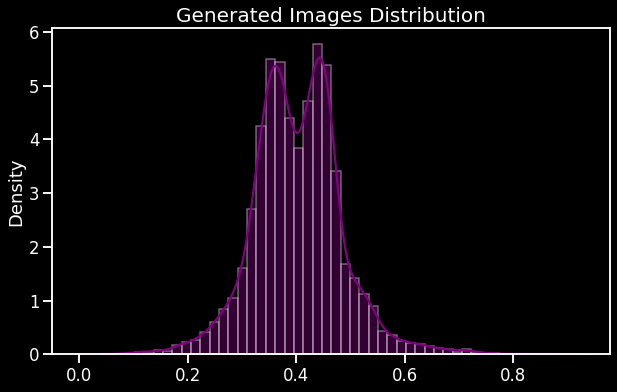

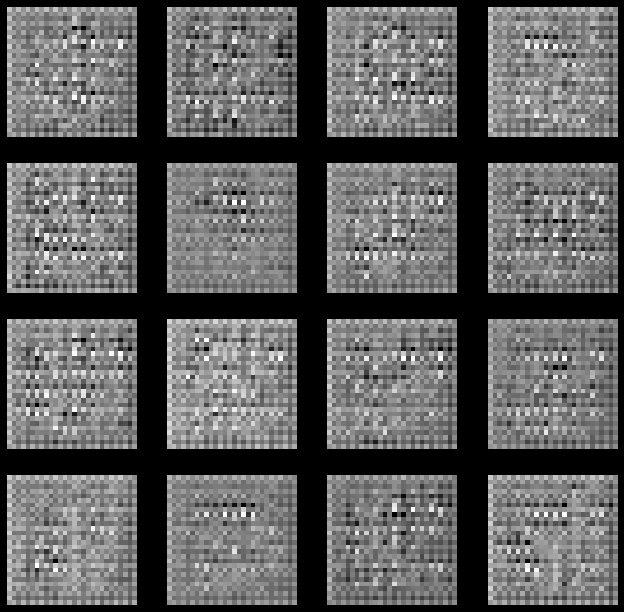

40 [D loss: 0.030355, accuracy: 98.44%] [G loss: 0.022797]


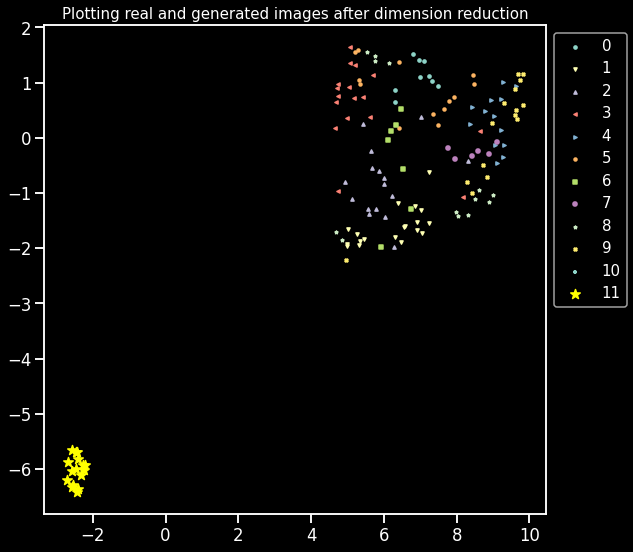

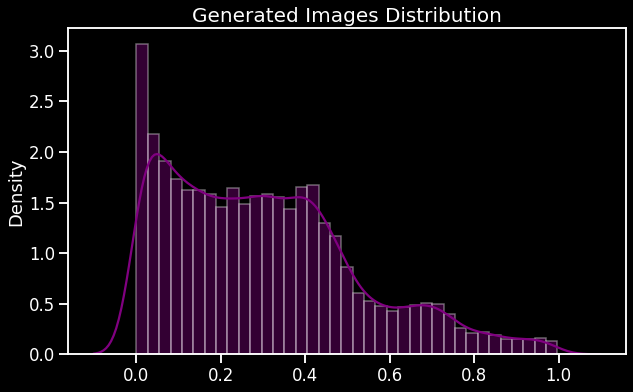

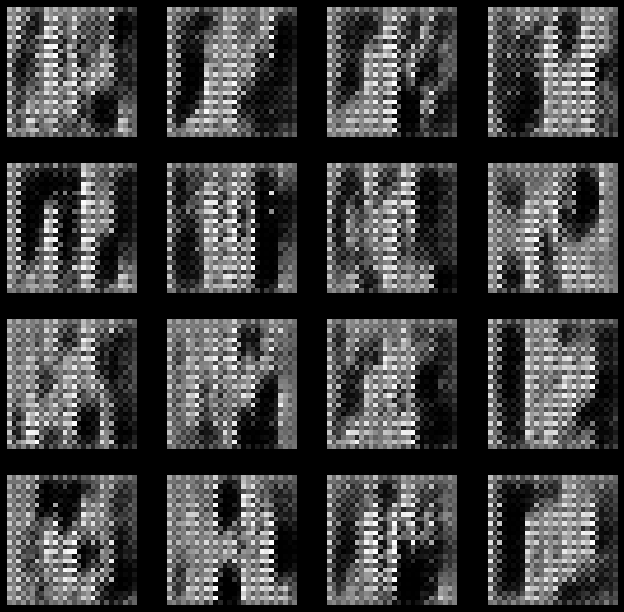

60 [D loss: 0.001931, accuracy: 100.00%] [G loss: 0.004134]


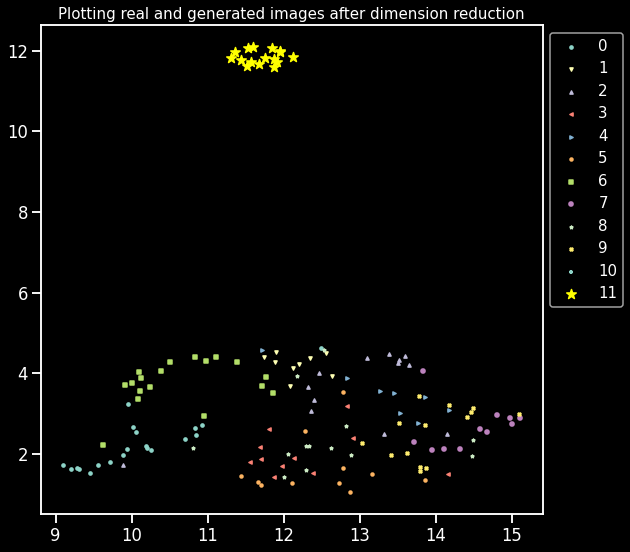

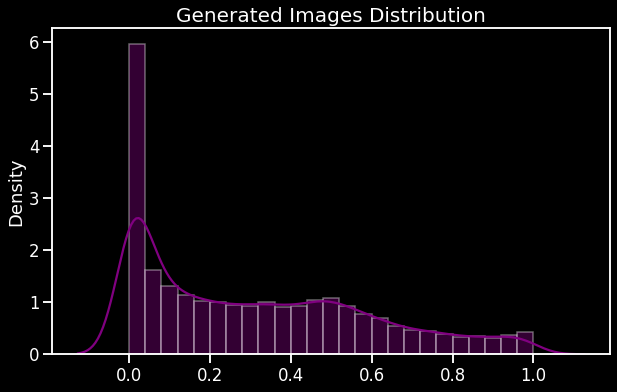

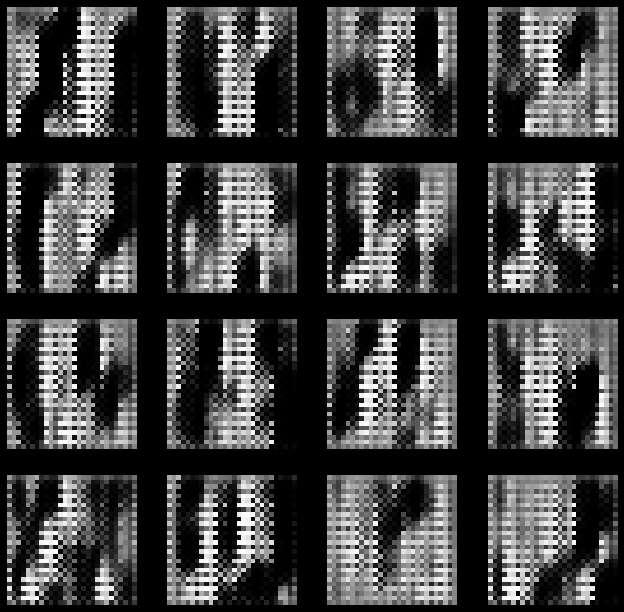

80 [D loss: 2.412184, accuracy: 51.17%] [G loss: 2.537326]


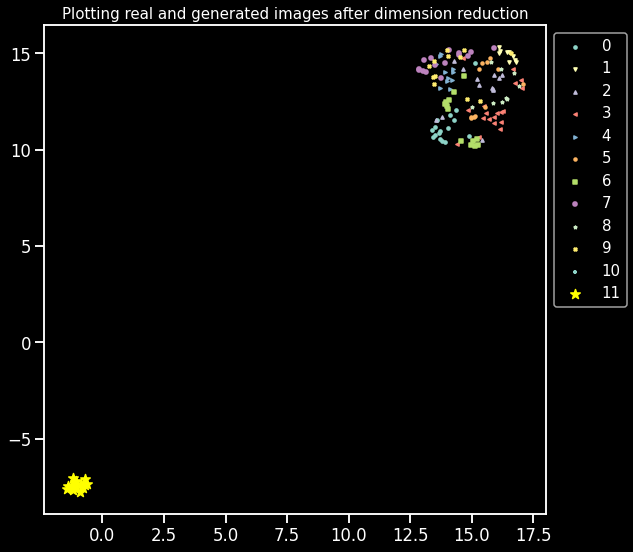

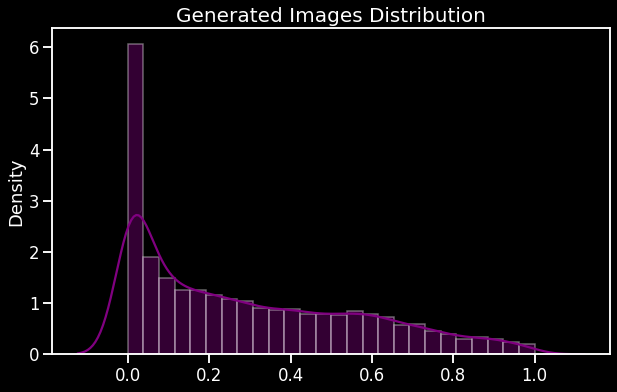

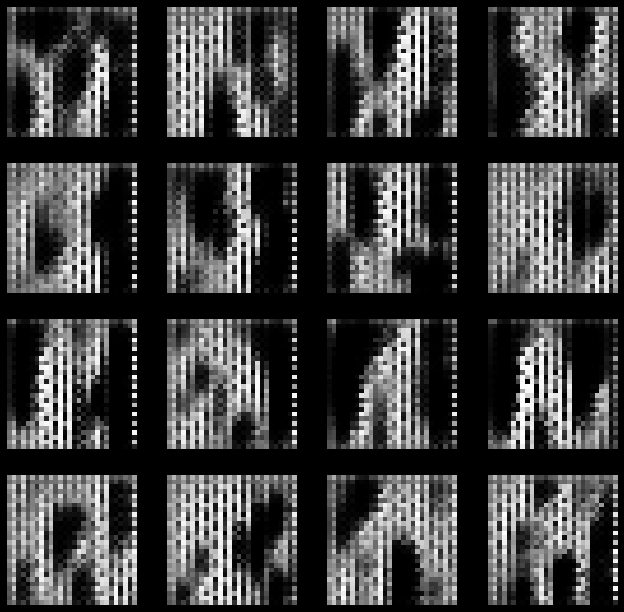

100 [D loss: 0.006977, accuracy: 100.00%] [G loss: 0.088903]


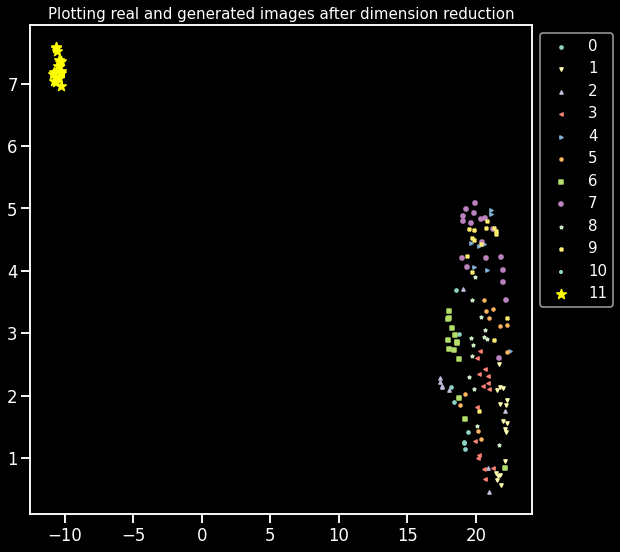

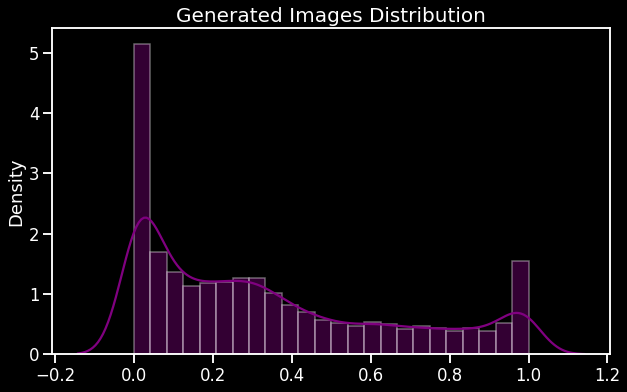

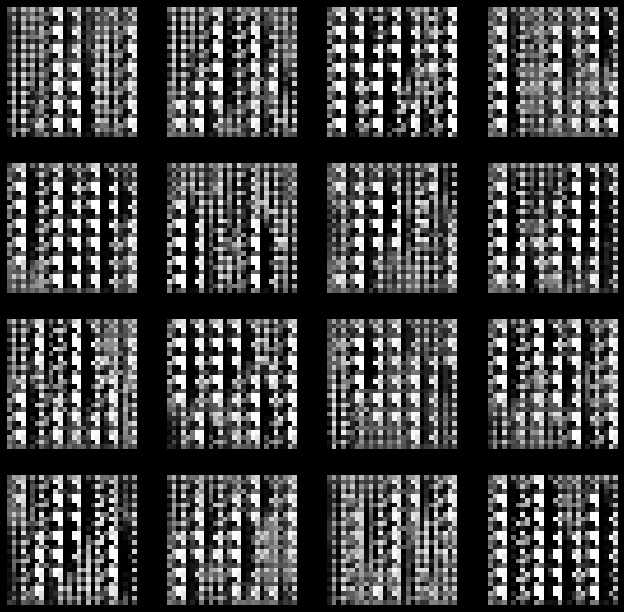

120 [D loss: 0.003986, accuracy: 100.00%] [G loss: 0.173664]


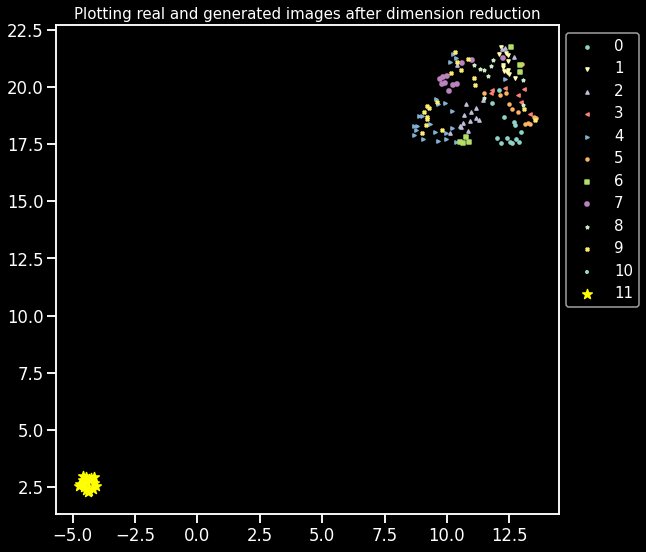

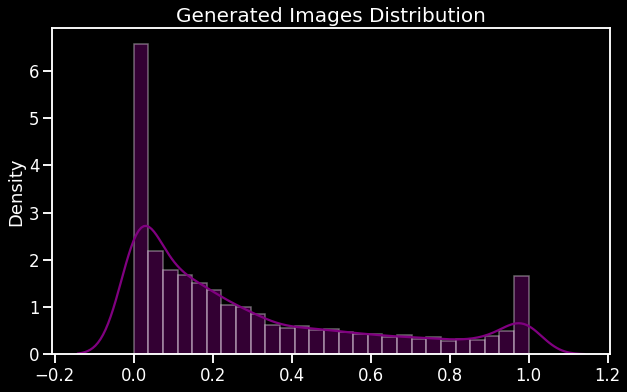

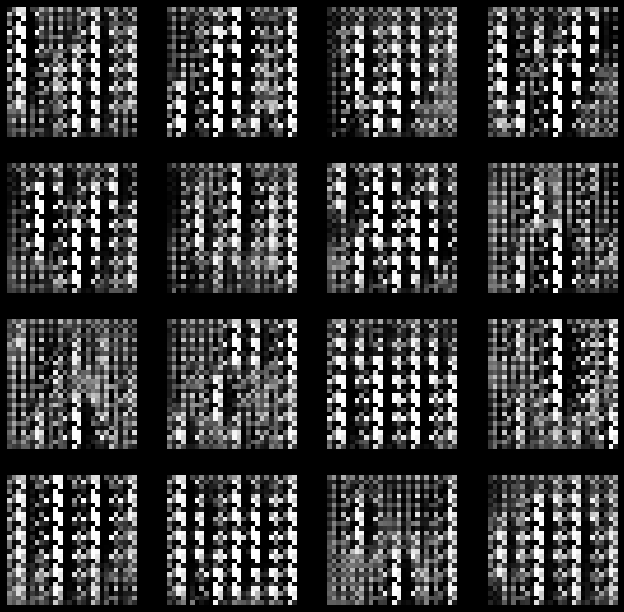

140 [D loss: 0.010667, accuracy: 100.00%] [G loss: 0.277202]


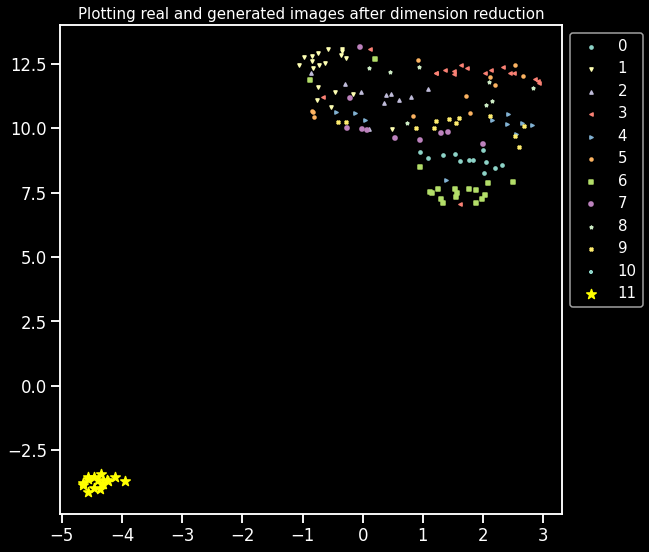

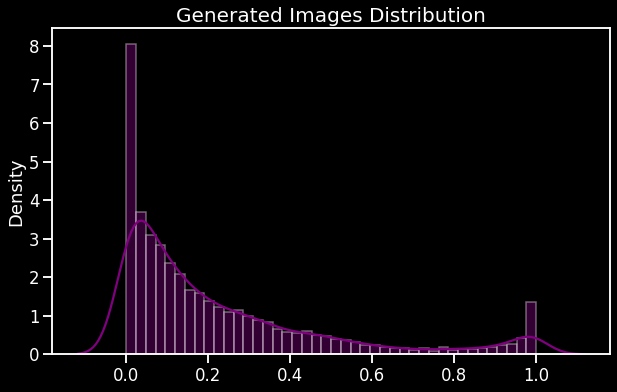

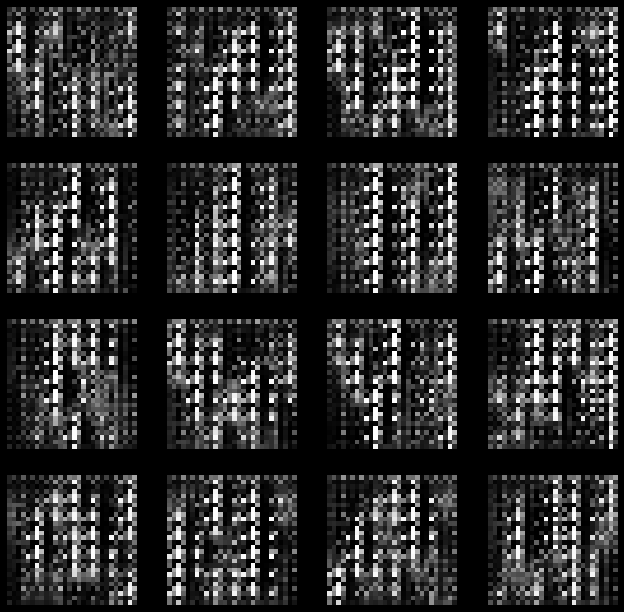

160 [D loss: 0.029600, accuracy: 99.61%] [G loss: 0.311917]


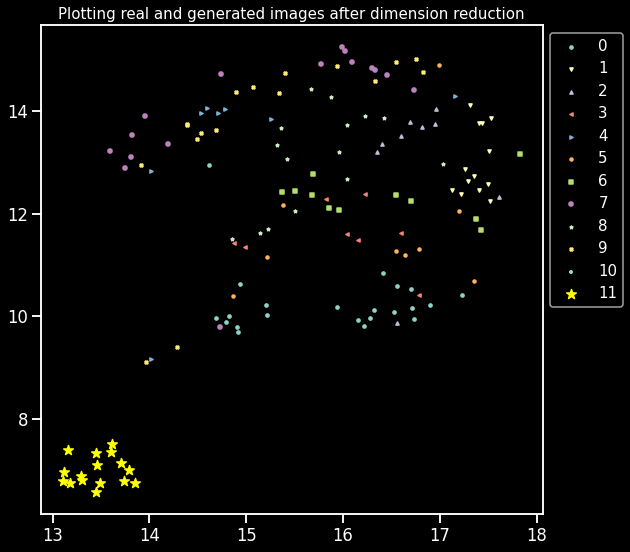

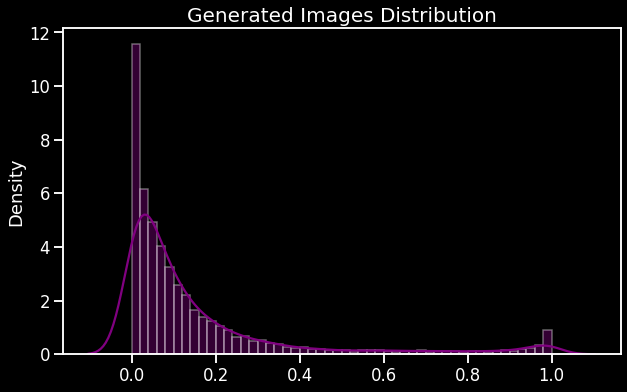

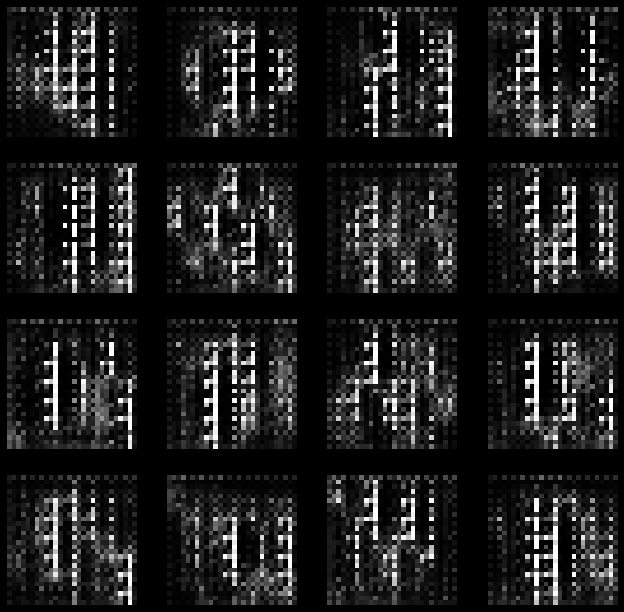

180 [D loss: 0.066238, accuracy: 98.44%] [G loss: 1.472796]


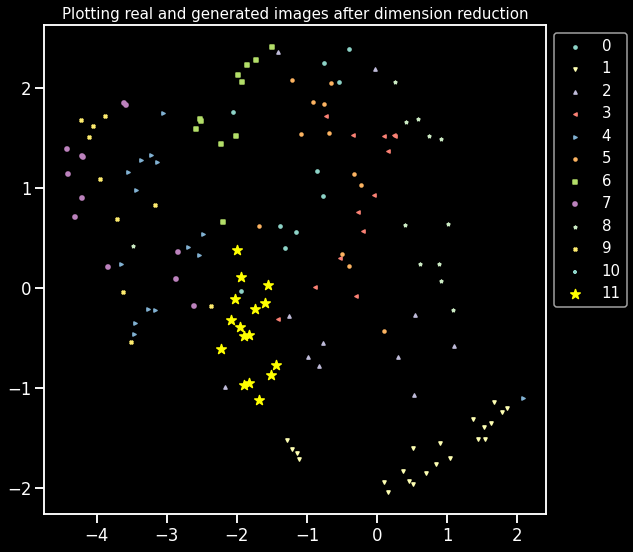

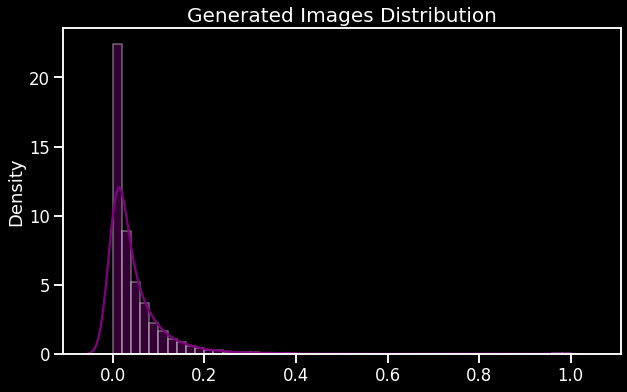

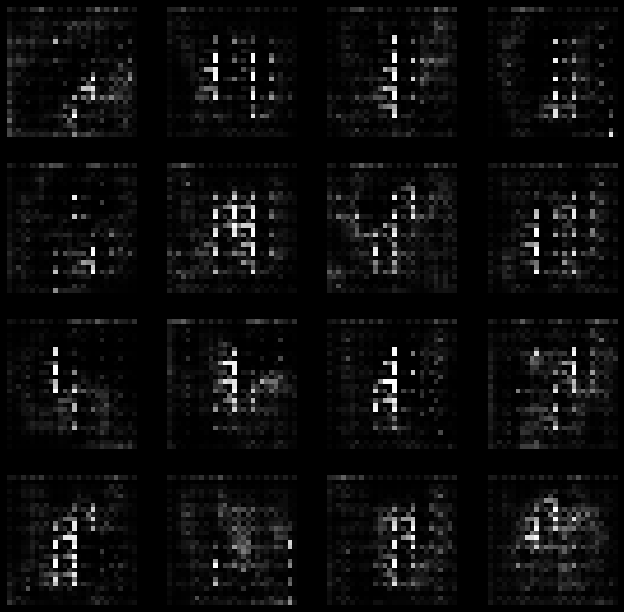

200 [D loss: 0.007410, accuracy: 99.61%] [G loss: 4.186689]


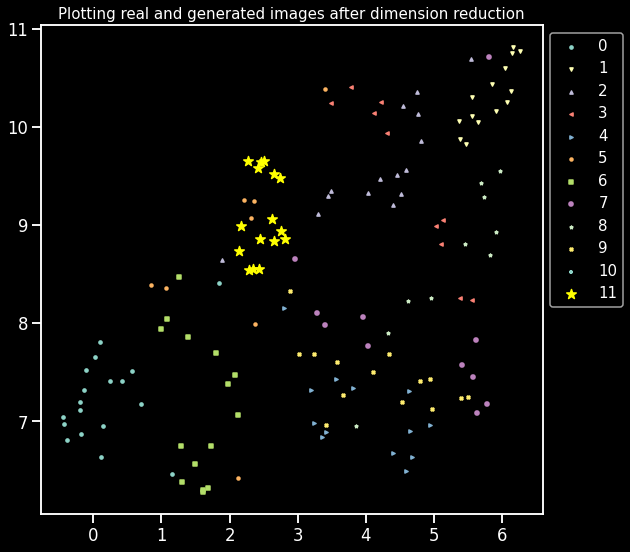

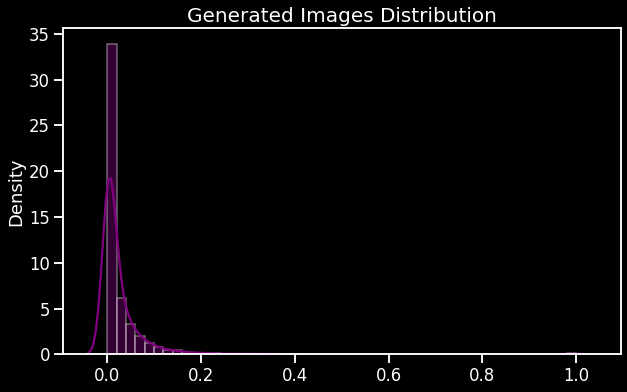

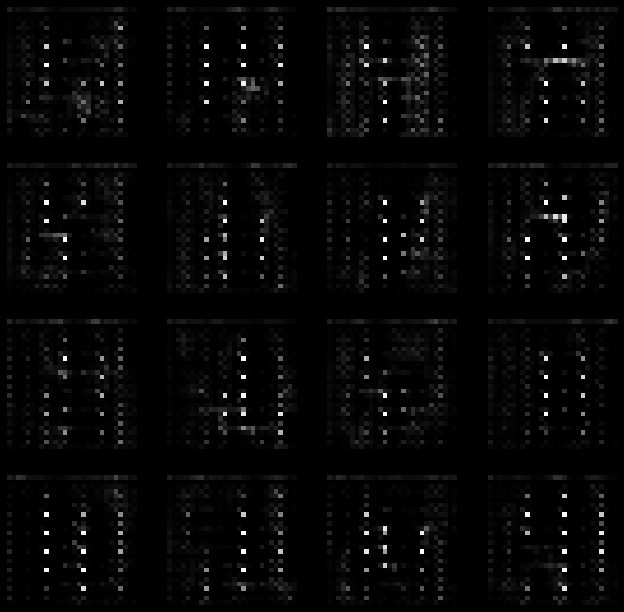

400 [D loss: 0.628298, accuracy: 76.95%] [G loss: 2.866495]


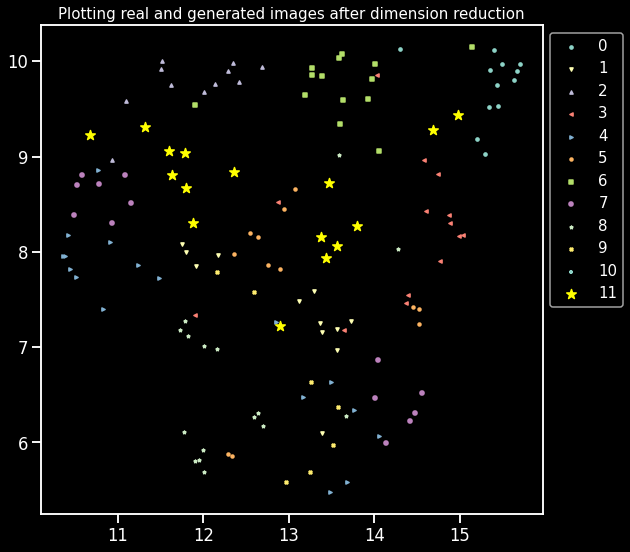

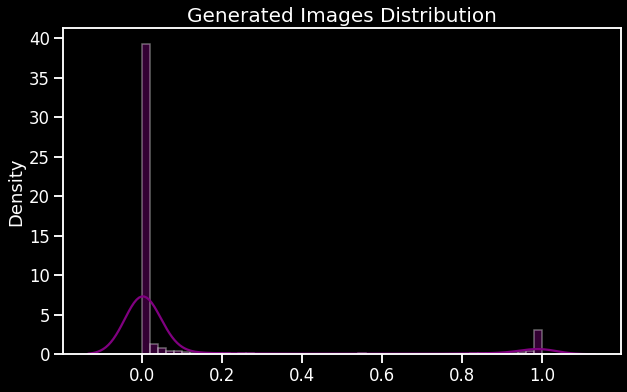

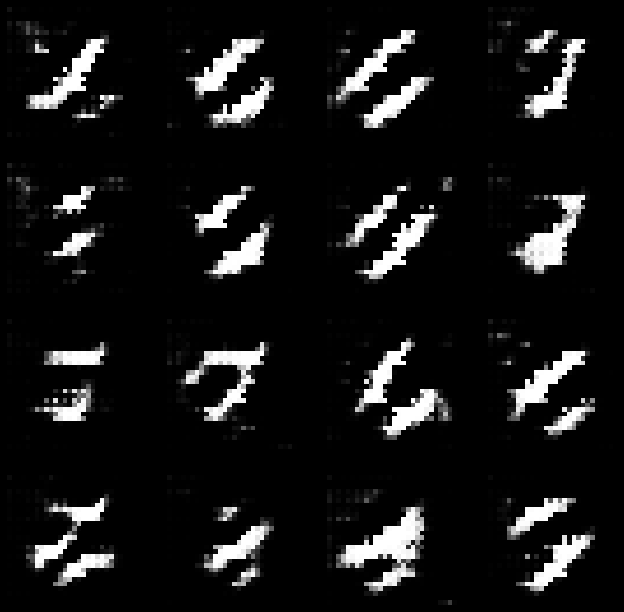

800 [D loss: 0.459017, accuracy: 79.30%] [G loss: 2.162340]


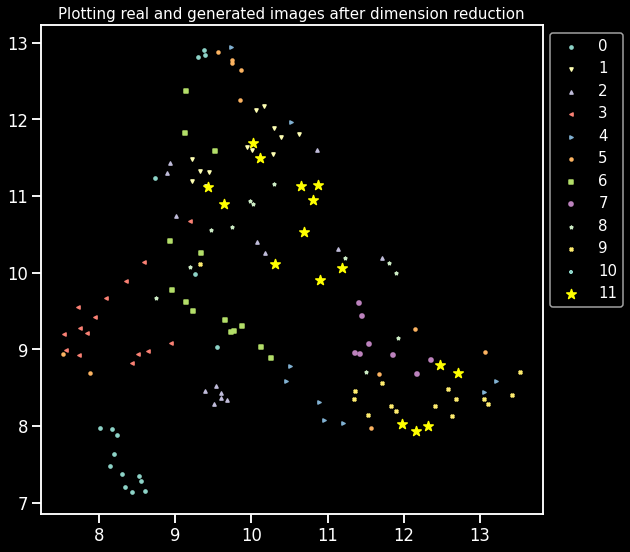

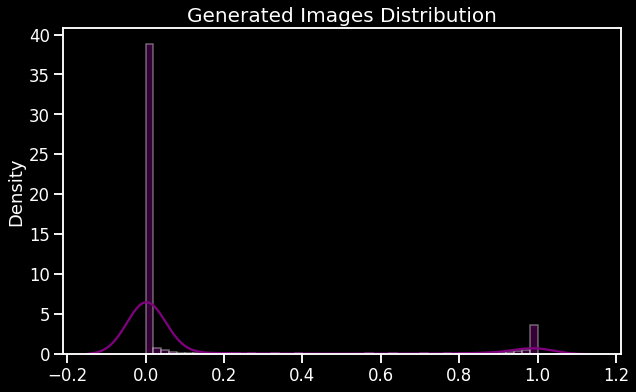

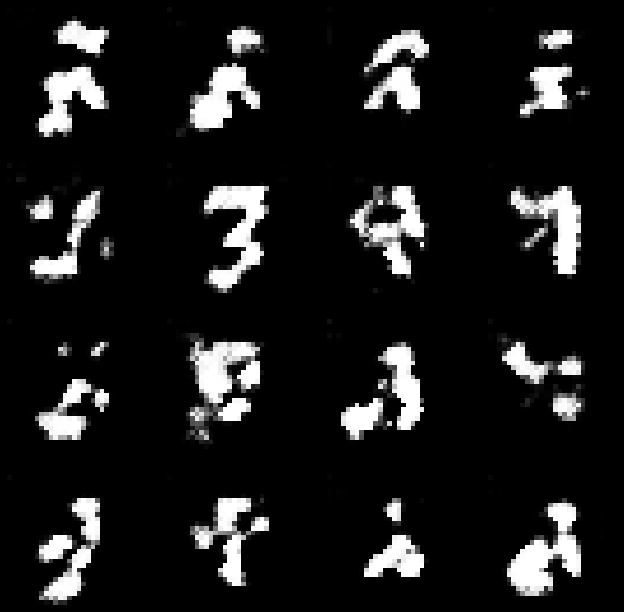

1200 [D loss: 0.361360, accuracy: 84.38%] [G loss: 2.012710]


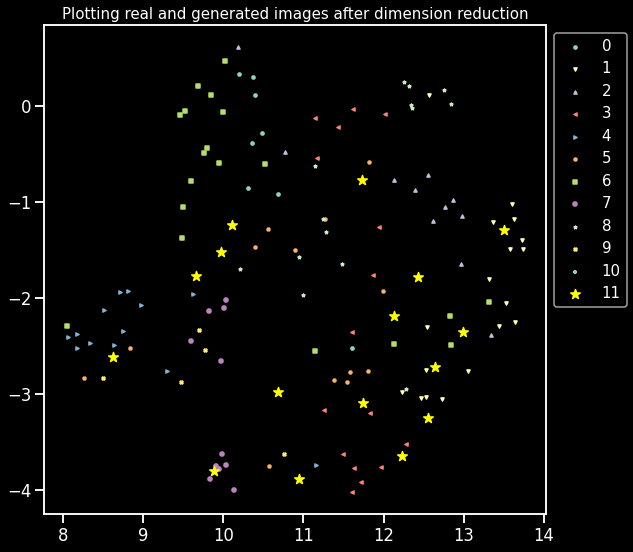

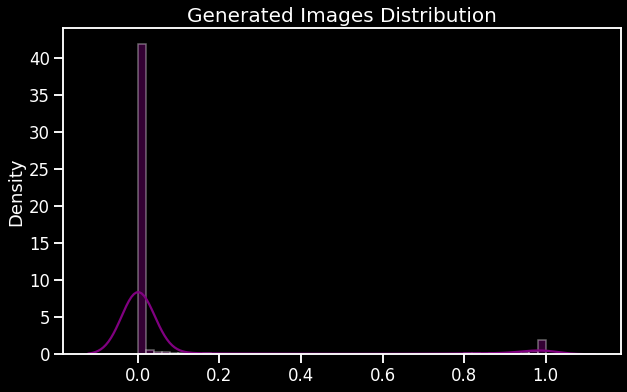

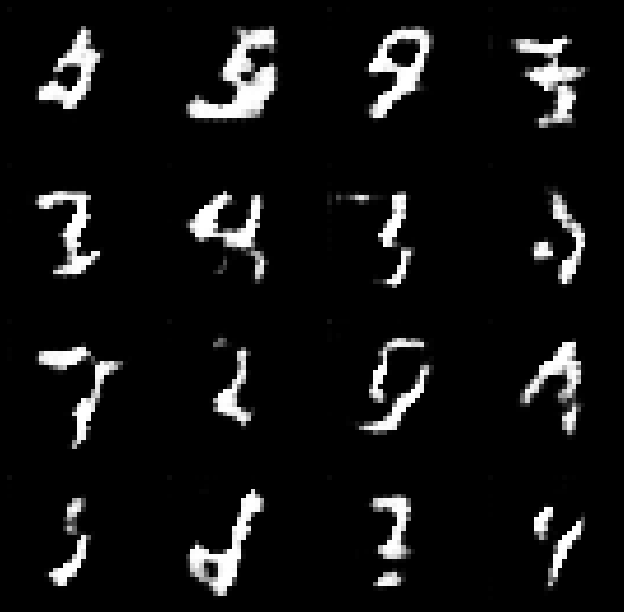

1600 [D loss: 0.356750, accuracy: 87.89%] [G loss: 1.693522]


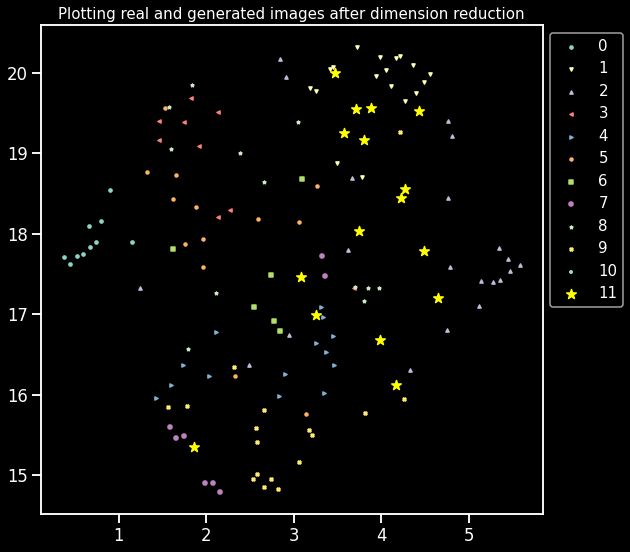

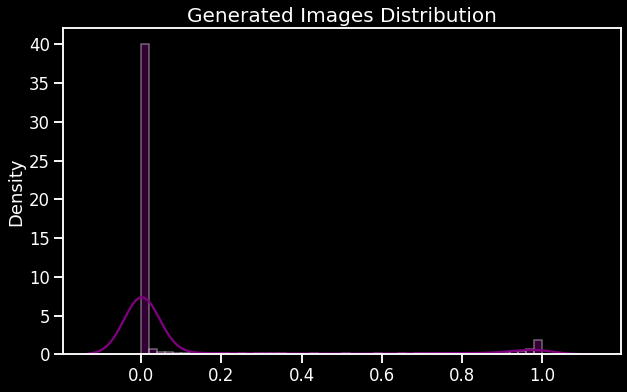

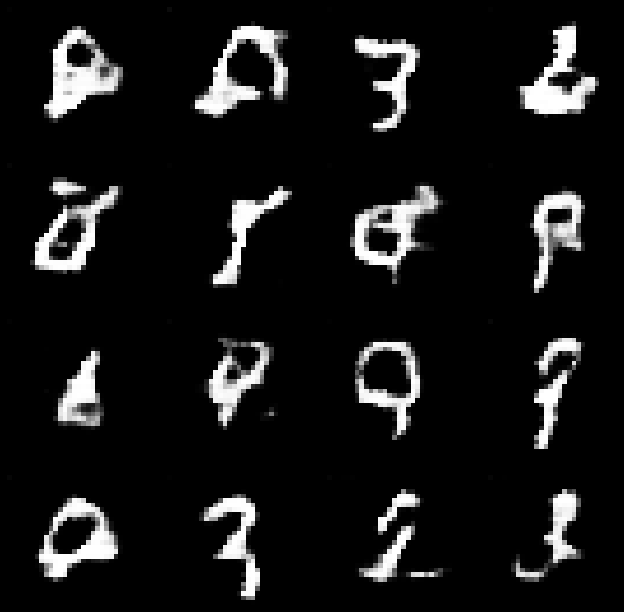

2000 [D loss: 0.393332, accuracy: 83.98%] [G loss: 1.657018]


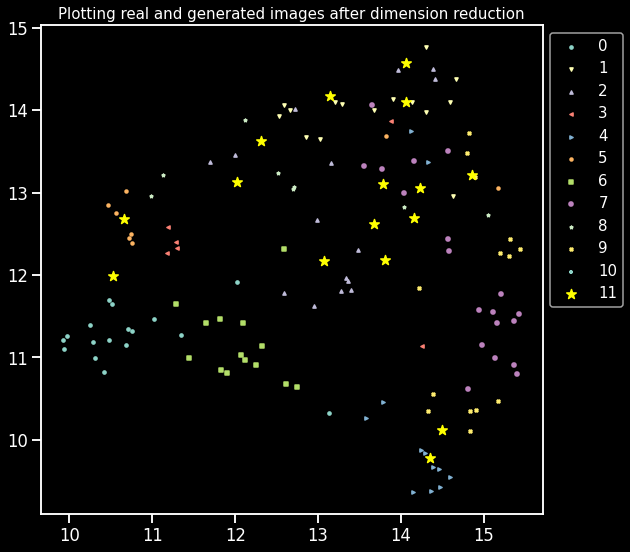

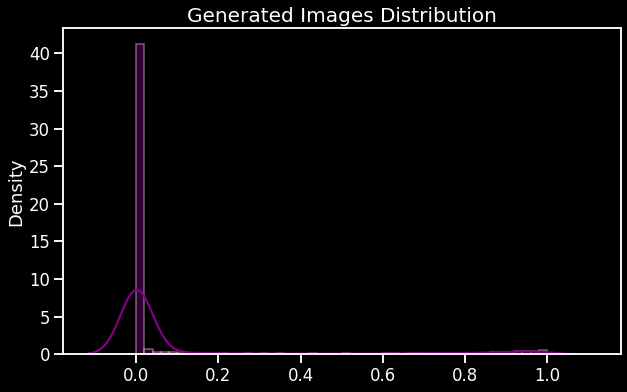

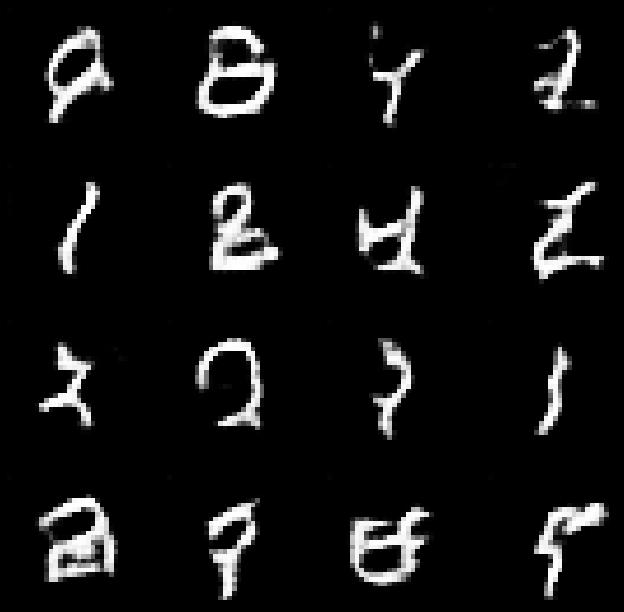

2400 [D loss: 0.512820, accuracy: 73.44%] [G loss: 1.551797]


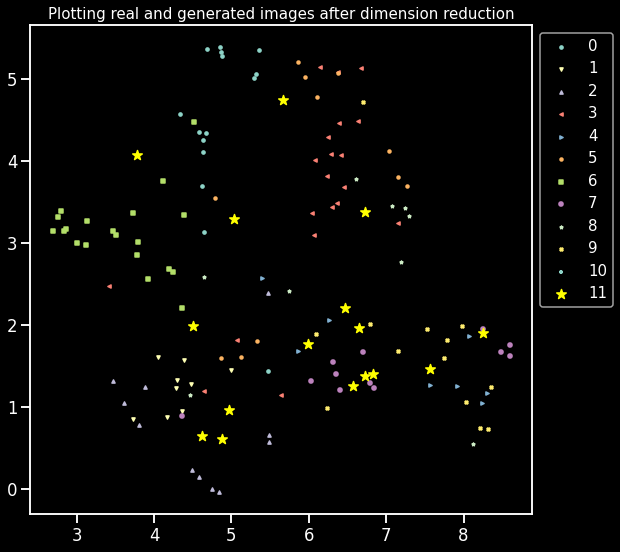

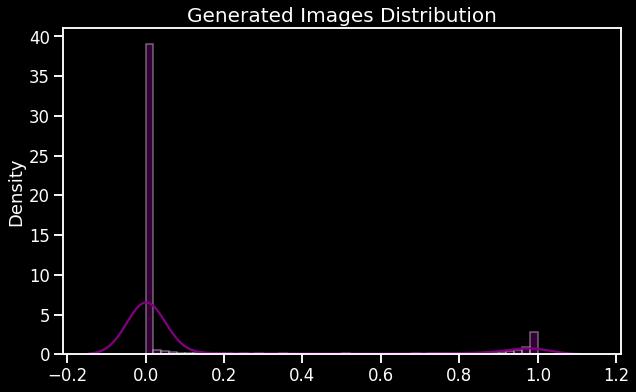

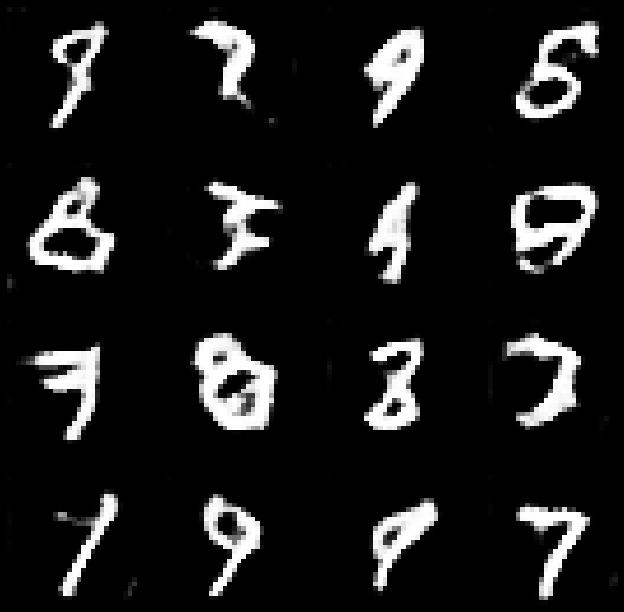

2800 [D loss: 0.426941, accuracy: 80.08%] [G loss: 1.511415]


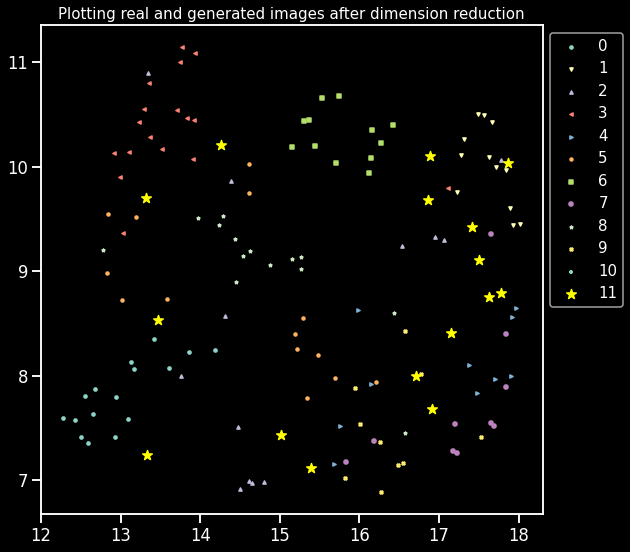

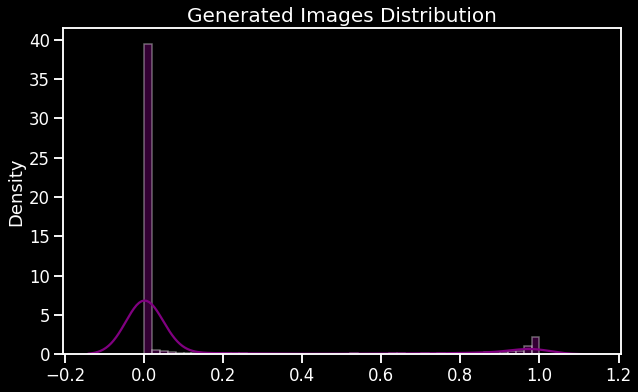

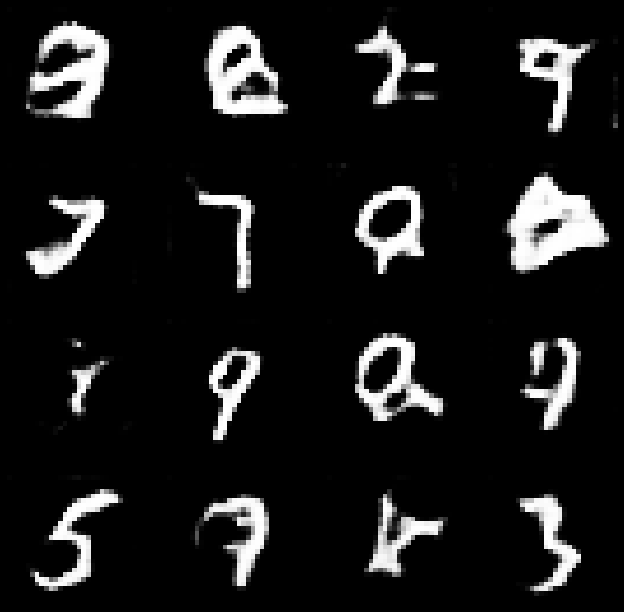

3200 [D loss: 0.408513, accuracy: 78.91%] [G loss: 1.822119]


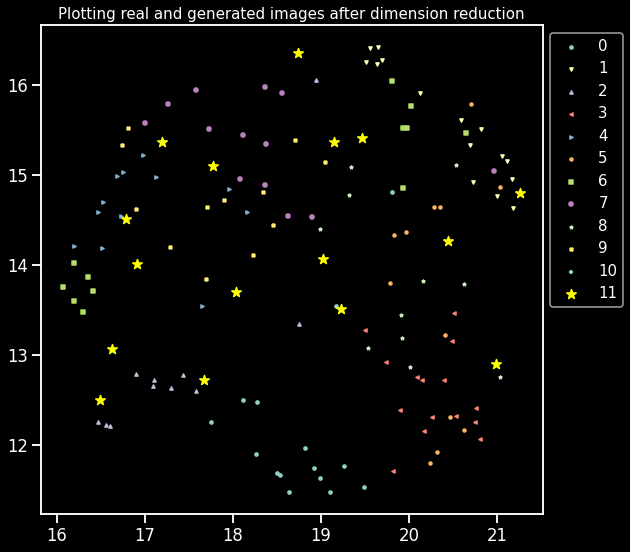

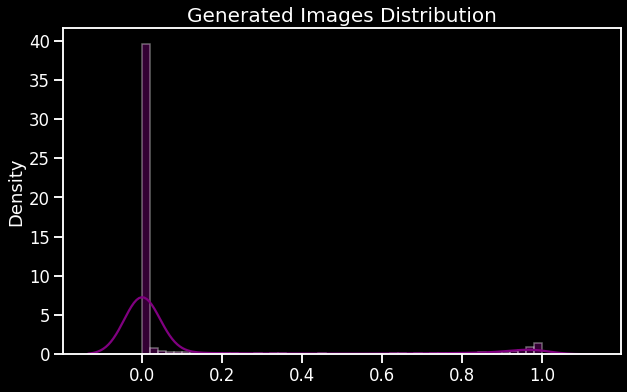

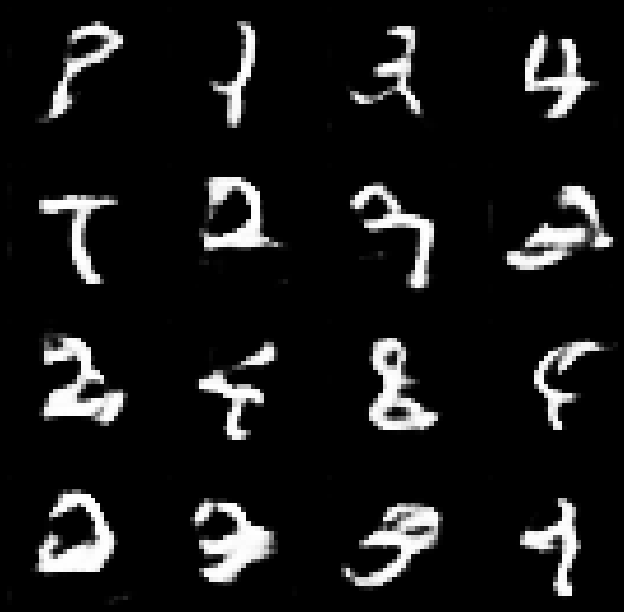

In [13]:
# DCGAN training for a specified number of iterations
train(iterations, batch_size, sample_interval)

If you look at the above results, you can see the process that starts with a random image and gradually changes to handwritten numeric data. With more iterations you will get clearer handwriting.


Also, please pay attention to the change in the distribution of the generated image. It can be said that this is the core at which GAN works. In other words, it learns the distribution of real data from a random distribution and uses it to create a real fake.

**Looking at the UMAP plot, it is very interesting. Our yellow stars are finding their place, as if they were in distant galaxies and returning to their original homes.**

---------------------------------------------------------------------------------
# Checking Results

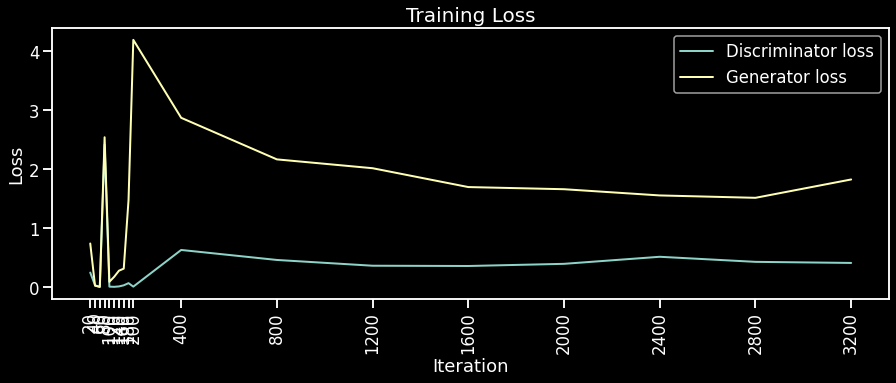

In [14]:
losses = np.array(losses)

# Training loss graph of discriminant and generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss",linewidth=2)
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss",linewidth=2)

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss",fontsize = 20)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

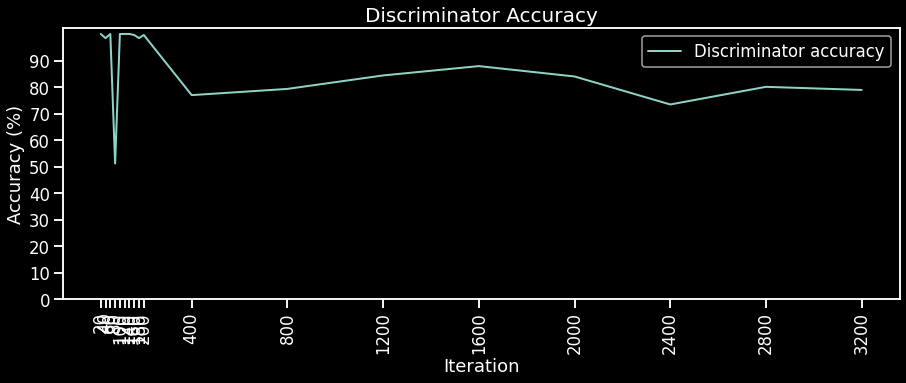

In [15]:
accuracies = np.array(accuracies)

# Discriminator Accuracy Graph
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy",linewidth=2)

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 10))

plt.title("Discriminator Accuracy",fontsize = 20)
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

-----------------------------------------------
# Conclusion

More training is needed to get better results. However, the purpose of this notebook is to understand how DCGAN creates plausible generated images from random noise images.
In addition, since training of GAN requires a lot of time, we will be satisfied with the results obtained now.

<hr style="border: solid 3px blue;">